In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
import numpy as np
np.random.seed(42)

import tensorflow as tf
tf.random.set_seed(42)

import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

#from utils import confusion_matrix



In [166]:
csv_filename = '/content/drive/MyDrive/motionProject/2023-02-22_6axis_data.csv'
df = pd.read_csv(csv_filename, encoding='utf8', low_memory=False) # utf8, cp949 |
df.shape


(6057, 8)

In [167]:
display(df.head())

display(df.tail())

,dataId,label,accX,accY,accZ,gyroX,gyroY,gyroZ
0,1,walk,-7.5852,-2.4024,3.8285,162.0059,-63.1548,182.5998
1,1,walk,-7.8150,-2.5220,3.9386,161.3194,-17.8481,128.3690
2,1,walk,-8.1021,-2.5699,4.4028,131.1149,28.1451,32.2639
3,1,walk,-8.2457,-2.4311,4.3980,83.7488,68.6466,-23.3398
4,1,walk,-8.2313,-2.5460,4.3837,45.3067,85.1217,-37.0691


,dataId,label,accX,accY,accZ,gyroX,gyroY,gyroZ
6052,109,walk,-7.9968,-1.6941,4.5655,105.0292,11.6699,-48.0526
6053,109,walk,-7.8102,-1.6654,4.5176,128.3690,1.3729,-50.7984
6054,109,walk,-8.2265,-1.4931,4.6899,135.2337,-17.8481,-59.7225
6055,109,walk,-8.7386,-1.4788,4.8718,128.3690,-26.7722,-92.6728
6056,109,walk,-8.7817,-1.6223,5.0201,84.4353,-48.7390,-95.4187


In [168]:
train = df[['accX','accY','accZ','gyroX','gyroY','gyroZ']]

In [169]:
test = df['label']

In [170]:
test.unique()

array(['walk', 'fallforward', 'idle'], dtype=object)

In [171]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.33, random_state=42)
# train-test data split
# X는 input, Y는 (정답)output

In [172]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4058, 6), (1999, 6), (4058,), (1999,))

In [173]:
epochs = 30
batch_size = 16
n_hidden = 64

In [174]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [175]:
# To reshape the data, convert the DataFrames to NumPy arrays first and then perform the reshape operation.

X_train = X_train.values
X_test = X_test.values

In [176]:
X_train

array([[-9.293700e+00, -2.785200e+00,  2.292300e+00,  6.178190e+01,
         2.883160e+01, -3.981500e+01],
       [-9.561700e+00, -1.435700e+00,  2.498100e+00, -2.134908e+02,
        -1.208179e+02, -1.379796e+02],
       [-9.064000e+00,  6.220000e-02,  4.120400e+00, -2.745900e+00,
        -2.196690e+01, -1.029700e+01],
       ...,
       [-9.810600e+00, -1.129400e+00,  1.067200e+00, -5.972250e+01,
         6.658720e+01, -1.002240e+02],
       [-1.100700e+01, -2.857000e+00,  2.584000e-01, -2.471280e+01,
        -2.656621e+02,  1.221909e+02],
       [-9.073600e+00,  5.740000e-02,  4.163500e+00,  1.372900e+00,
        -2.333980e+01,  7.551100e+00]])

In [177]:
y_train = y_train.values
y_test = y_test.values

In [178]:
# reshape input to be 3D [samples, timesteps, features]
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [179]:
X_train.shape

(4058, 1, 6)

In [180]:
X_test.shape

(1999, 1, 6)

In [181]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4058, 1, 6) (4058,) (1999, 1, 6) (1999,)


In [182]:
# 분류하고 싶은 클래스 개수
n_classes = _count_classes(y_train) 
n_classes

3

In [183]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
# ['PC' 'TABLET' 'MOBILE'] ==> [1 2 0]

In [184]:
from keras.utils import to_categorical

# 원 핫 인코딩 
#    0 1 2
# 1  0 1 0
# 2  0 0 1
# 0  1 0 0

y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

In [185]:
model = Sequential()

# n_hidden : 은닉계층에 임베딩되는 차원
# LSTM cell =  n_hidden 차원으로 만드는 것
# timestep : split해서 넣을 데이터 절편 크기
model.add(LSTM(n_hidden, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# input차원 - (timesteps, input_dim)
model.add(Dropout(0.5))
model.add(LSTM(n_hidden))
model.add(Dropout(0.5))


model.add(Dense(n_classes, activation='softmax'))

# loss : predicted 결과와 real 결과의 차이
# optimizer : local optimum에 빠지지 않도록 넘어가게 해주는 장치, Adam 많이 씀
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/30
254/254 [==============================] - 9s 16ms/step - loss: 0.8486 - accuracy: 0.6079 - val_loss: 0.6886 - val_accuracy: 0.6943
Epoch 2/30
254/254 [==============================] - 2s 7ms/step - loss: 0.6849 - accuracy: 0.7008 - val_loss: 0.5918 - val_accuracy: 0.7429
Epoch 3/30
254/254 [==============================] - 2s 6ms/step - loss: 0.6055 - accuracy: 0.7442 - val_loss: 0.5277 - val_accuracy: 0.7649
Epoch 4/30
254/254 [==============================] - 2s 7ms/step - loss: 0.5556 - accuracy: 0.7743 - val_loss: 0.4896 - val_accuracy: 0.7944
Epoch 5/30
254/254 [==============================] - 2s 6ms/step - loss: 0.5324 - accuracy: 0.7743 - val_loss: 0.4756 - val_accuracy: 0.8034
Epoch 6/30
254/254 [==============================] - 2s 7ms/step - loss: 0.5188 - accuracy: 0.7827 - val_loss: 0.4624 - val_accuracy: 0.7904
Epoch 7/30
254/254 [==============================] - 2s 6ms/step - loss: 0.5096 - accuracy: 0.7792 - val_loss: 0.4468 - val_accuracy: 0.8069
Epoch

In [188]:
from keras.models import load_model

model.save('/content/drive/MyDrive/motionProject/lstm_model.h5')
model.summary()

#from google.colab import files
#files.download('saved_model')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1, 64)             18176     
                                                                 
 dropout_13 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_16 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
Total params: 51,395
Trainable params: 51,395
Non-trainable params: 0
_________________________________________________________________


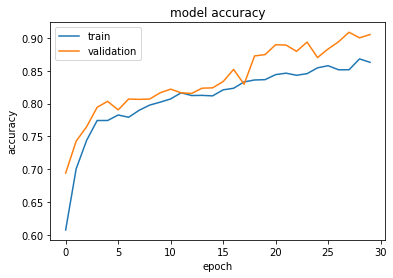

In [186]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [161]:
from sklearn.metrics import confusion_matrix

y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(model.predict(X_test), axis=1)
print(confusion_matrix(y_test_classes, y_pred_classes))

63/63 [==============================] - 0s 2ms/step
[[271   0  27]
 [ 17 695 120]
 [  5 123 741]]


### 랜덤 인풋에 따른 예측결과

In [157]:
model_new = tf.keras.models.load_model("/content/drive/MyDrive/motionProject/lstm_model.h5")

In [121]:
test_data1 = np.array([[-100 , -10 , 6 , -224 , -224 , -112], [-101 , -9 , 4 , -56 , -203 , -161], [-100 , -9 , 8 , 7 , -196 , -112]])

In [122]:
test_data1.shape

(3, 6)

In [123]:
test_data1 = np.reshape(test_data1, (len(test_data1), 1, 6))

In [124]:
test_data1.shape

(3, 1, 6)

In [125]:
label = test.unique()
label

array(['walk', 'sit', 'fallforward', 'idle', 'standup'], dtype=object)

In [126]:
np_class = np.argmax(model_new.predict(test_data1), axis=1)
np_class

1/1 [==============================] - 1s 1s/step


array([1, 1, 1])

In [127]:
label[np_class[0]]

'sit'

In [39]:
test_data2 = np.array([-100 , -10 , 6 , -224 , -224 , -112])
test_data2 = np.reshape(test_data2, (1, 1, len(test_data2)))
label = test.unique()
np_class = np.argmax(model.predict(test_data2), axis=1)
label[np_class[0]]

1/1 [==============================] - 1s 860ms/step


'fallforward'